In [9]:
# TASK 0 - Load olivetti_faces data and save it to mongodb database

import pickle
from pymongo import MongoClient
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
from bson.binary import Binary

olivetti = fetch_olivetti_faces()
client = MongoClient("mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db=client.admin
mwdb_database = client["mwdb_database"]
olivetti_faces_col = mwdb_database["olivetti_faces"]
count=0
for j in np.array(olivetti.images):
    olivetti_faces_col.insert_one({"_id":count, "image_matrix": Binary( pickle.dumps(j, protocol=2) ) })
    count+=1


InvalidDocument: cannot encode object: array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.37190083, 0.3305785 ,
        0.30578512],
       [0.3429752 , 0.40495867, 0.43801653, ..., 0.37190083, 0.338843  ,
        0.3140496 ],
       [0.3429752 , 0.41735536, 0.45041323, ..., 0.38016528, 0.338843  ,
        0.29752067],
       ...,
       [0.21487603, 0.20661157, 0.2231405 , ..., 0.15289256, 0.16528925,
        0.17355372],
       [0.20247933, 0.2107438 , 0.2107438 , ..., 0.14876033, 0.16115703,
        0.16528925],
       [0.20247933, 0.20661157, 0.20247933, ..., 0.15289256, 0.16115703,
        0.1570248 ]], dtype=float32), of type: <class 'numpy.ndarray'>

Color Moment Result for Image 100


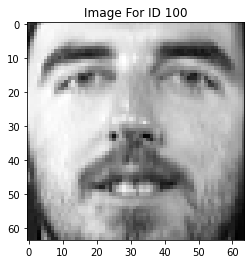

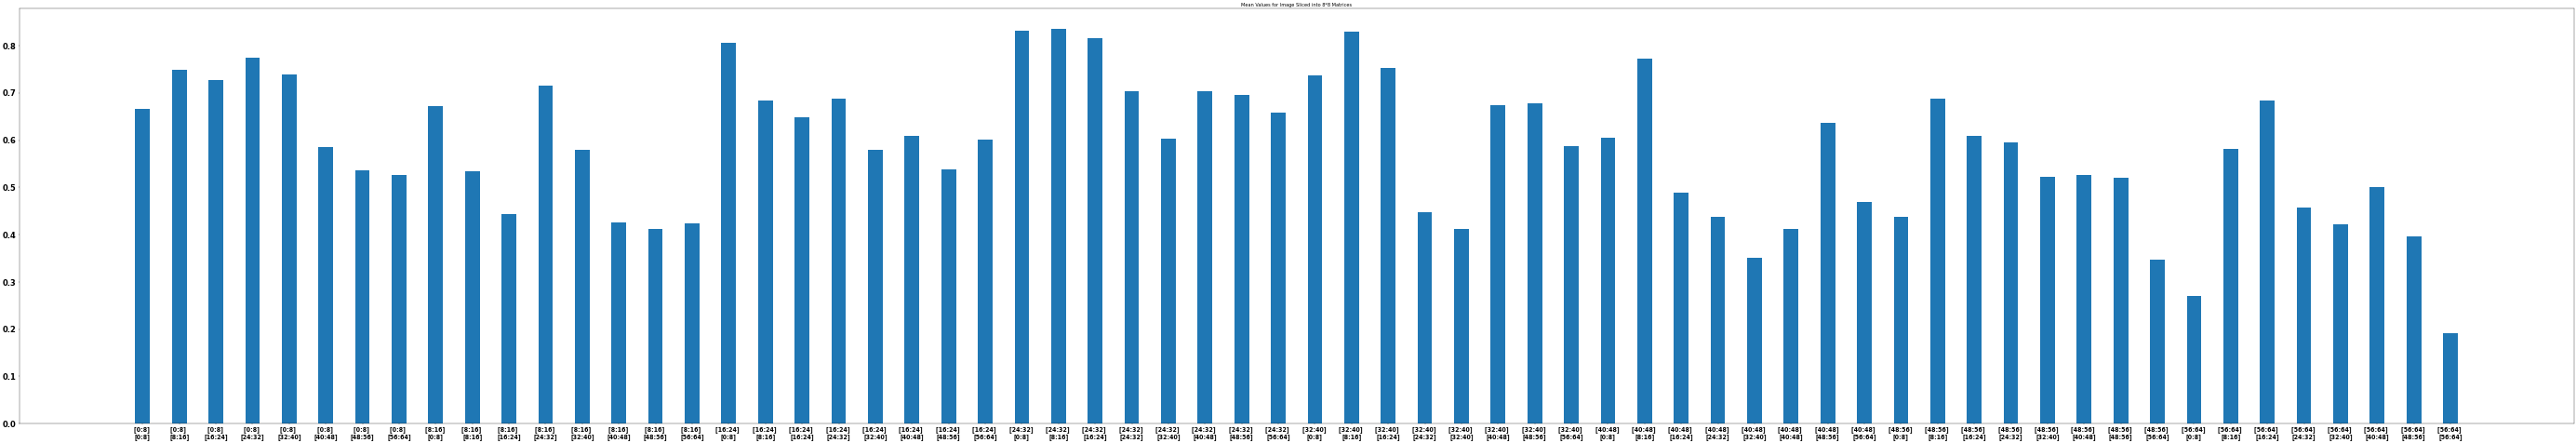

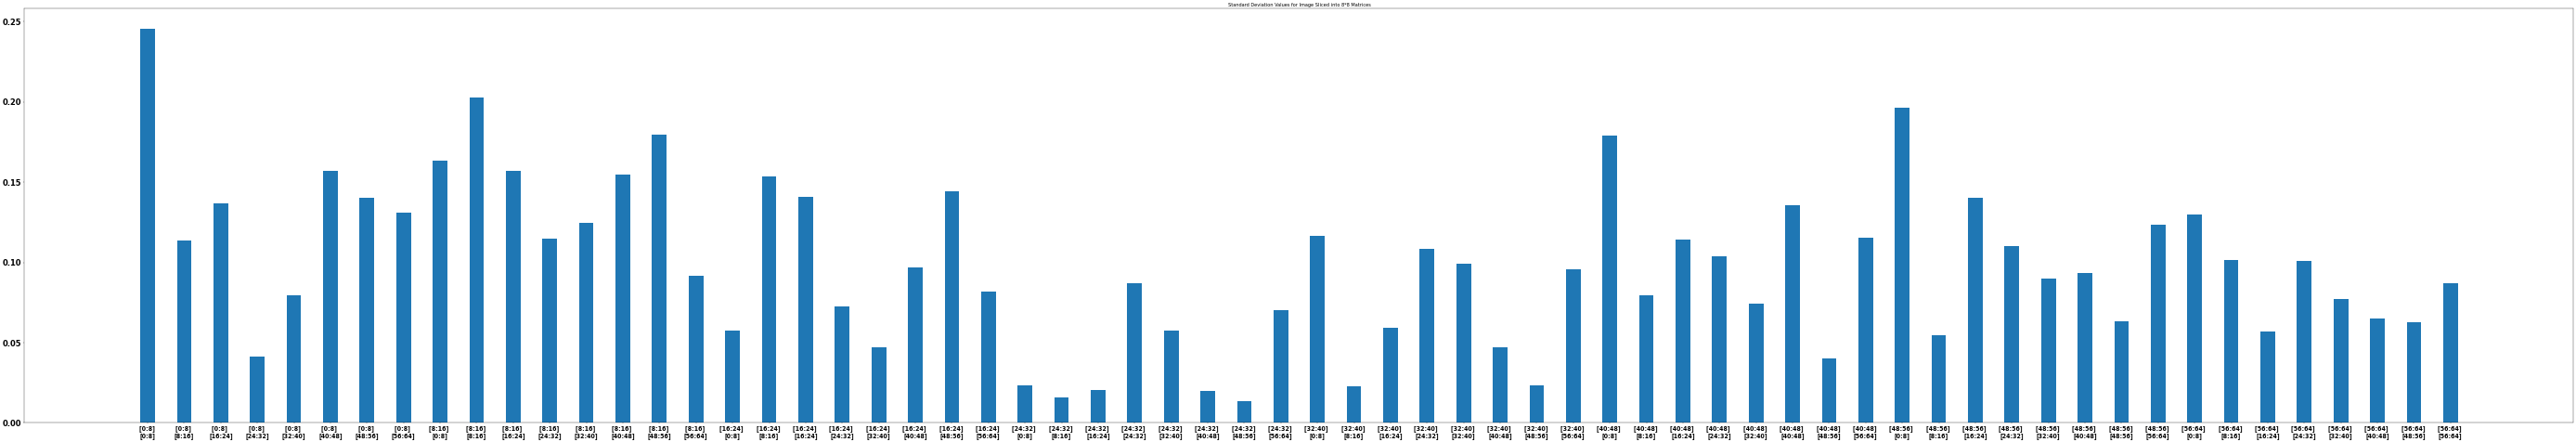

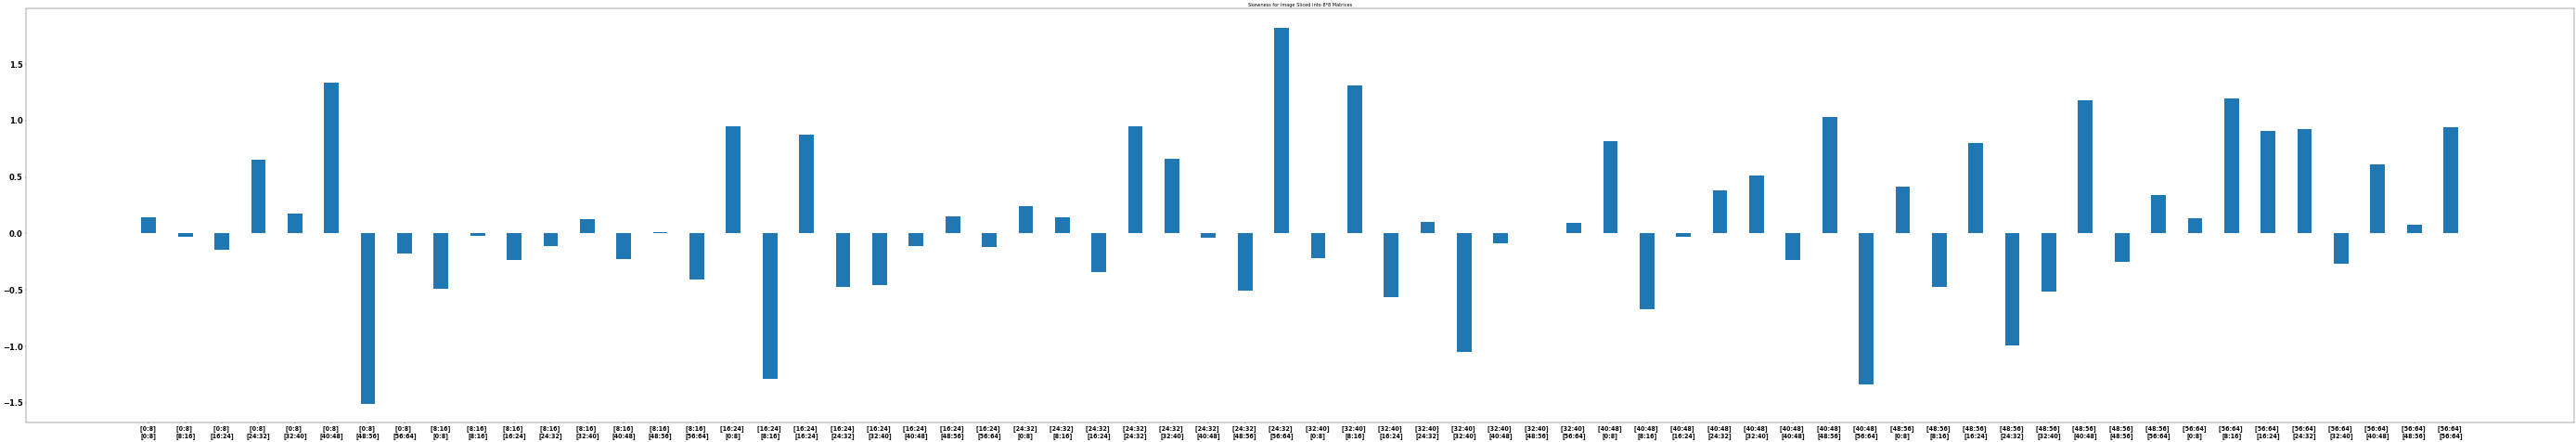

In [26]:
#TASK - 1: Added all 3 models on the requested image

from scipy.stats import skew
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from pymongo import MongoClient
from skimage import exposure


import pickle
import matplotlib.pyplot as plt
import numpy as np


def apply_model_on_olivetti_face(image_id, model_name):
    if image_id < 0 or image_id > 399:
        print("No Image of this ID Exist " + str(image_id))
        return

    client = MongoClient("mongodb://localhost:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false")
    db = client.admin
    mwdb_database = client["mwdb_database"]
    olivetti_faces_col = mwdb_database["olivetti_faces"]

    data_image = olivetti_faces_col.find_one({'_id': image_id})
    binary_data = data_image['image_matrix']
    image_matrix = pickle.loads(binary_data)
    plt.figure()
    plt.title("Image For ID " + str(image_id))
    plt.imshow(image_matrix, interpolation='nearest')
    plt.gray()
    if model_name == "color_moment":
        color_moment_model(image_id, image_matrix)
    elif model_name == "local_binary_pattern":
        local_binary_pattern_model(image_id, image_matrix)
    elif model_name == "histogram_of_oriented_gradients":
        histogram_of_oriented_gradients_model(image_id, image_matrix)
    else:
        print("No Model of the given name exist = " + model_name)

    return


def cm_to_inch(value):
    return value / 2.54


def color_moment_model(image_id, image_matrix):
    mean_of_sliced_image = {}
    std_dev_of_sliced_image = {}
    skew_of_sliced_image = {}
    for row in range(0, 8):
        for col in range(0, 8):
            sliced_image = image_matrix[row * 8:(row * 8) + 8, col * 8:(col * 8) + 8]
            mean_of_sliced_image["[" + str(row * 8) + ":" + str((row * 8) + 8) + "] \n[" + str(col * 8) + ":" + str(
                (col * 8) + 8) + "]"] = sliced_image.mean()
            std_dev_of_sliced_image["[" + str(row * 8) + ":" + str((row * 8) + 8) + "] \n[" + str(col * 8) + ":" + str(
                (col * 8) + 8) + "]"] = np.std(sliced_image)
            skew_of_sliced_image["[" + str(row * 8) + ":" + str((row * 8) + 8) + "] \n[" + str(col * 8) + ":" + str(
                (col * 8) + 8) + "]"] = skew(skew(sliced_image))
    print("Color Moment Result for Image " + str(image_id))
    labels = []
    ys = []
    for x, y in mean_of_sliced_image.items():
        labels.append(x)
        ys.append(y)

    xs = np.arange(len(labels))
    width = 0.4
    plt.figure(figsize=(cm_to_inch(300), cm_to_inch(50)), dpi=30, facecolor='w', edgecolor='r')
    plt.bar(xs, ys, width)
    plt.title("Mean Values for Image Sliced into 8*8 Matrices")
    plt.xticks(xs, labels, fontsize=15, weight='bold',
               horizontalalignment="center")  # Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(fontsize=20, weight='bold')
    plt.plot()

    labels = []
    ys = []
    for x, y in std_dev_of_sliced_image.items():
        labels.append(x)
        ys.append(y)

    xs = np.arange(len(labels))
    width = 0.4
    plt.figure(figsize=(cm_to_inch(300), cm_to_inch(50)), dpi=30, facecolor='w', edgecolor='r')
    plt.bar(xs, ys, width)
    plt.title("Standard Deviation Values for Image Sliced into 8*8 Matrices")
    plt.xticks(xs, labels, fontsize=15, weight='bold',
               horizontalalignment="center")  # Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(fontsize=20, weight='bold')
    plt.plot()

    labels = []
    ys = []
    for x, y in skew_of_sliced_image.items():
        labels.append(x)
        ys.append(y)

    xs = np.arange(len(labels))
    width = 0.4
    plt.figure(figsize=(cm_to_inch(300), cm_to_inch(50)), dpi=30, facecolor='w', edgecolor='r')
    plt.bar(xs, ys, width)
    plt.title("Skewness for Image Sliced into 8*8 Matrices")
    plt.xticks(xs, labels, fontsize=15, weight='bold',
               horizontalalignment="center")  # Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(fontsize=20, weight='bold')
    plt.plot()
    plt.show()

    return


def local_binary_pattern_model(image_id, image_matrix):
    print("Local Binary Pattern Result for Image "+ str(image_id))
    neighbour_set_points = 8
    radius = 1.00
    patterns = local_binary_pattern(image_matrix, neighbour_set_points, radius, method='ror')

    plt.figure()
    plt.title("Image After Applying ELBP")
    plt.imshow(patterns, interpolation='nearest')
    plt.gray()

    hist, _ = np.histogram(patterns, bins=np.arange(2 ** 3 + 1), density=True)

    plt.figure()
    plt.title("Image Graph after ELBP")
    plt.plot(hist)
    plt.ylim([0, hist.max()])
    plt.xlim([0, 7])
    plt.show()

    return

def histogram_of_oriented_gradients_model(image_id, image_matrix):
    print("Histogram of Oriented Gradients Result for Image "+ str(image_id))
    fd, hog_image = hog(image_matrix, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(8, 8), block_norm='L2-Hys', visualize=True, multichannel=0)
    fig, ax2 = plt.subplots(figsize=(8, 4), sharex=True, sharey=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ax2.imshow(hog_image_rescaled)
    ax2.set_title('Image After Applying HOG')
    plt.show()

    return


#apply_model_on_olivetti_face(100, "local_binary_pattern")
apply_model_on_olivetti_face(100, "color_moment")
#apply_model_on_olivetti_face(0, "histogram_of_oriented_gradients")


In [ ]:
#TASK - 2: Added all 3 models on the requested folder

from matplotlib.backends.backend_pdf import PdfPages
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from matplotlib import image
from scipy.stats import skew
from skimage import exposure

import os, os.path
import matplotlib.pyplot as plt
import numpy as np


def read_folder_and_generate_report(folder_path):
    valid_images = [".jpg", ".png"]

    for f in os.listdir(folder_path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue

        image_file = image.imread(os.path.join(folder_path, f))
        output_file = PdfPages("output/task_2/" + os.path.splitext(f)[0] + '_output.pdf')

        first_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w',
                                edgecolor='r')
        first_page.clf()
        title = 'OUTPUT FOR THE ' + os.path.splitext(f)[0]
        first_page.text(0.5, 0.5, title, transform=first_page.transFigure, size=500, ha="center")
        output_file.savefig()
        plt.close(first_page)

        plot_0 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
        plt.imshow(image_file, interpolation='nearest', cmap='gray')
        output_file.savefig(plot_0)
        plt.close(plot_0)

        color_moment_model(f, image_file, output_file)
        local_binary_pattern_model(f, image_file, output_file)
        histogram_of_oriented_gradients_model(f, image_file, output_file)

        output_file.close()

    return


def cm_to_inch(value):
    return value / 2.54


def color_moment_model(image_id, image_matrix, output_file):
    mean_of_sliced_image = {}
    std_dev_of_sliced_image = {}
    skew_of_sliced_image = {}
    for row in range(0, 8):
        for col in range(0, 8):
            sliced_image = image_matrix[row * 8:(row * 8) + 8, col * 8:(col * 8) + 8]
            mean_of_sliced_image["[" + str(row * 8) + ":" + str((row * 8) + 8) + "] \n[" + str(col * 8) + ":" + str(
                (col * 8) + 8) + "]"] = sliced_image.mean()
            std_dev_of_sliced_image["[" + str(row * 8) + ":" + str((row * 8) + 8) + "] \n[" + str(col * 8) + ":" + str(
                (col * 8) + 8) + "]"] = np.std(sliced_image)
            skew_of_sliced_image["[" + str(row * 8) + ":" + str((row * 8) + 8) + "] \n[" + str(col * 8) + ":" + str(
                (col * 8) + 8) + "]"] = skew(skew(sliced_image))

    color_moment_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w',
                                   edgecolor='r')
    color_moment_page.clf()
    color_moment_page_title = 'I - Color Moment Result'
    color_moment_page.text(0.5, 0.5, color_moment_page_title, transform=color_moment_page.transFigure, size=250,
                           ha="center")
    output_file.savefig()
    plt.close(color_moment_page)

    labels = []
    ys = []
    for x, y in mean_of_sliced_image.items():
        labels.append(x)
        ys.append(y)

    mean_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    mean_page.clf()
    mean_title = 'i - Mean Values for Image Sliced into 8*8 Matrices'
    mean_page.text(0.5, 0.5, mean_title, transform=mean_page.transFigure, size=250, ha="center")
    output_file.savefig()
    plt.close(mean_page)

    xs = np.arange(len(labels))
    width = 0.6
    plot_1 = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(150)), dpi=80, facecolor='w', edgecolor='r')
    plt.bar(xs, ys, width, align='edge')
    plt.xticks(xs, labels, fontsize=40, weight='bold',
               horizontalalignment="center")  # Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(fontsize=100, weight='bold')
    output_file.savefig(plot_1, orientation='portrait')
    plt.close(plot_1)

    labels = []
    ys = []
    for x, y in std_dev_of_sliced_image.items():
        labels.append(x)
        ys.append(y)

    std_dev_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    std_dev_page.clf()
    std_dev_title = 'ii - Standard Deviation Values for Image Sliced into 8*8 Matrices'
    std_dev_page.text(0.5, 0.5, std_dev_title, transform=std_dev_page.transFigure, size=250, ha="center")
    output_file.savefig()
    plt.close(std_dev_page)

    xs = np.arange(len(labels))
    width = 0.6
    plot_2 = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(150)), dpi=80, facecolor='w', edgecolor='r')
    plt.bar(xs, ys, width, align='edge')
    plt.xticks(xs, labels, fontsize=40, weight='bold',
               horizontalalignment="center")  # Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(fontsize=100, weight='bold')
    output_file.savefig(plot_2)
    plt.close(plot_2)

    labels = []
    ys = []
    for x, y in skew_of_sliced_image.items():
        labels.append(x)
        ys.append(y)

    skew_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    skew_page.clf()
    skew_title = 'iii - Skewness for Image Sliced into 8*8 Matrices'
    skew_page.text(0.5, 0.5, skew_title, transform=skew_page.transFigure, size=250, ha="center")
    output_file.savefig()
    plt.close(skew_page)

    xs = np.arange(len(labels))
    width = 0.6
    plot_3 = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(150)), dpi=80, facecolor='w', edgecolor='r')
    plt.bar(xs, ys, width, align='edge')
    plt.xticks(xs, labels, fontsize=40, weight='bold',
               horizontalalignment="center")  # Replace default x-ticks with xs, then replace xs with labels
    plt.yticks(fontsize=100, weight='bold')
    output_file.savefig(plot_3)
    plt.close(plot_3)

    return


def local_binary_pattern_model(image_id, image_matrix, output_file):
    local_binary_pattern_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w',
                                           edgecolor='r')
    local_binary_pattern_page.clf()
    local_binary_pattern_page_title = 'II - Local Binary Pattern Result'
    local_binary_pattern_page.text(0.5, 0.5, local_binary_pattern_page_title,
                                   transform=local_binary_pattern_page.transFigure, size=250, ha="center")
    output_file.savefig()
    plt.close(local_binary_pattern_page)

    neighbour_set_points = 8
    radius = 1.00
    patterns = local_binary_pattern(image_matrix, neighbour_set_points, radius, method='ror')

    plot_4 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.imshow(patterns, interpolation='nearest', cmap='gray')
    output_file.savefig(plot_4)
    plt.close(plot_4)

    hist, _ = np.histogram(patterns, bins=np.arange(2 ** 3 + 1), density=True)

    plot_5 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.ylim([0, hist.max()])
    plt.yticks(fontsize=100, weight='bold')
    plt.xlim([0, 7])
    plt.xticks(fontsize=100, weight='bold')
    plt.plot(hist)
    output_file.savefig(plot_5)
    plt.close(plot_5)

    return


def histogram_of_oriented_gradients_model(image_id, image_matrix, output_file):
    hog_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    hog_page.clf()
    hog_page_title = 'III - Histogram of Oriented Gradients Result'
    hog_page.text(0.5, 0.5, hog_page_title, transform=hog_page.transFigure, size=250, ha="center")
    output_file.savefig()
    plt.close(hog_page)


    fd, hog_image = hog(image_matrix, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(8, 8), block_norm='L2-Hys', visualize=True, multichannel=0)
    plot_6, ax2 = plt.subplots(figsize=(cm_to_inch(200), cm_to_inch(200)), sharex=True, sharey=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    ax2.imshow(hog_image_rescaled, cmap='gray')
    output_file.savefig(plot_6)
    plt.close(plot_6)

    return


read_folder_and_generate_report(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces")

In [1]:
# TASK 3 - maybe wrong

from matplotlib.backends.backend_pdf import PdfPages
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from matplotlib import image
from scipy.stats import skew

import os, os.path
import matplotlib.pyplot as plt
import numpy as np
import itertools



def read_folder_and_get_similar_images(folder_path, image_id, model_name, k):
    valid_images = [".jpg", ".png"]

    if model_name == "color_moment":
        color_moment_model(folder_path, image_id, valid_images, k)
    elif model_name == "local_binary_pattern":
        local_binary_pattern_model(folder_path, image_id, valid_images, k)
    elif model_name == "histogram_of_oriented_gradients":
        histogram_of_oriented_gradients_model(folder_path, image_id, valid_images, k)
    else:
        print("No Model of the given name exist = " + model_name)
    return


def cm_to_inch(value):
    return value / 2.54


def color_moment_model(folder_path, image_id, valid_images, k):
    # k_nearest = [0] * k
    main_image_matrix = image.imread(os.path.join(folder_path, image_id))
    total_cost = {}

    main_image_color_moments = [[0] * 64 for _ in range(3)]
    main_count = 0
    for row in range(0, 8):
        for col in range(0, 8):
            sliced_image = main_image_matrix[row * 8:(row * 8) + 8, col * 8:(col * 8) + 8]

            main_image_color_moments[0][main_count] = sliced_image.mean()
            main_image_color_moments[1][main_count] = np.std(sliced_image)
            main_image_color_moments[2][main_count] = skew(skew(sliced_image))
            main_count += 1

    for f in os.listdir(folder_path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        if f == image_id:
            continue

        image_matrix = image.imread(os.path.join(folder_path, f))
        color_moments = [[0] * 64 for _ in range(3)]
        count = 0

        for row in range(0, 8):
            for col in range(0, 8):
                sliced_image = image_matrix[row * 8:(row * 8) + 8, col * 8:(col * 8) + 8]

                color_moments[0][count] = sliced_image.mean()
                color_moments[1][count] = np.std(sliced_image)
                color_moments[2][count] = skew(skew(sliced_image))
                count += 1

        total_cost[f] = np.linalg.norm(np.array(main_image_color_moments) - np.array(color_moments), ord=2)

    total_cost = {
        k: v for k, v in zip(
            sorted(total_cost.keys()),
            sorted(total_cost.values(),
                   key=lambda x: (abs(x))
                   )
        )
    }

    if k <= len(total_cost):
        total_cost = dict(itertools.islice(total_cost.items(), k))

    output_file = PdfPages("output/task_3/" + os.path.splitext(image_id)[0] + '_color-moment_output.pdf')
    first_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    first_page.clf()
    title = 'COLOR MOMENTS OUTPUT FOR THE ' + os.path.splitext(image_id)[0] + " for " + str(k) + "-similar images"
    first_page.text(0.5, 0.5, title, transform=first_page.transFigure, size=500, ha="center")
    output_file.savefig()
    plt.close(first_page)

    actual_image = image.imread(os.path.join(folder_path, image_id))
    plot_actual_image = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.title("Actual Image", fontdict={'fontsize': 200})
    plt.imshow(actual_image, interpolation='nearest', cmap='gray')
    output_file.savefig(plot_actual_image)
    plt.close(plot_actual_image)

    for key, value in total_cost.items():
        image_file = image.imread(os.path.join(folder_path, key))
        plot_0 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
        plt.title("Overall Matching Score = " + str(value), fontdict={'fontsize': 200})
        plt.imshow(image_file, interpolation='nearest', cmap='gray')
        output_file.savefig(plot_0)
        plt.close(plot_0)

    output_file.close()
    return


def local_binary_pattern_model(folder_path, image_id, valid_images, k):
    neighbour_set_points = 8
    radius = 1.00
    main_image_matrix = image.imread(os.path.join(folder_path, image_id))
    total_cost = {}
    main_image_lbp = local_binary_pattern(main_image_matrix, neighbour_set_points, radius, method='ror')

    for f in os.listdir(folder_path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        if f == image_id:
            continue

        image_matrix = image.imread(os.path.join(folder_path, f))
        image_lbp = local_binary_pattern(image_matrix, neighbour_set_points, radius, method='ror')
        total_cost[f] = np.linalg.norm(np.array(main_image_lbp) - np.array(image_lbp), ord=2)

    total_cost = {
        k: v for k, v in zip(
            sorted(total_cost.keys()),
            sorted(total_cost.values(),
                   key=lambda x: (abs(x))
                   )
        )
    }
    if k <= len(total_cost):
        total_cost = dict(itertools.islice(total_cost.items(), k))

    output_file = PdfPages("output/task_3/" + os.path.splitext(image_id)[0] + '_lpb_output.pdf')
    first_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    first_page.clf()
    title = 'LOCAL BINARY PATTERN OUTPUT FOR THE ' + os.path.splitext(image_id)[0] + " for " + \
            str(k) + "-similar images"
    first_page.text(0.5, 0.5, title, transform=first_page.transFigure, size=400, ha="center")
    output_file.savefig()
    plt.close(first_page)

    actual_image = image.imread(os.path.join(folder_path, image_id))
    plot_actual_image = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.title("Actual Image", fontdict={'fontsize': 200})
    plt.imshow(actual_image, interpolation='nearest', cmap='gray')
    output_file.savefig(plot_actual_image)
    plt.close(plot_actual_image)

    for key, value in total_cost.items():
        image_file = image.imread(os.path.join(folder_path, key))
        plot_0 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
        plt.title("Overall Matching Score = " + str(value), fontdict={'fontsize': 200})
        plt.imshow(image_file, interpolation='nearest', cmap='gray')
        output_file.savefig(plot_0)
        plt.close(plot_0)

    output_file.close()

    return


def histogram_of_oriented_gradients_model(folder_path, image_id, valid_images, k):
    main_image_matrix = image.imread(os.path.join(folder_path, image_id))
    total_cost = {}
    _, main_image_hog = hog(main_image_matrix, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(8, 8), block_norm='L2-Hys', visualize=True, multichannel=0)

    for f in os.listdir(folder_path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        if f == image_id:
            continue

        image_matrix = image.imread(os.path.join(folder_path, f))
        _, hog_image = hog(image_matrix, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(8, 8), block_norm='L2-Hys', visualize=True, multichannel=0)

        total_cost[f] = np.linalg.norm(np.array(main_image_hog) - np.array(hog_image), ord=2)

    total_cost = {
        k: v for k, v in zip(
            sorted(total_cost.keys()),
            sorted(total_cost.values(),
                   key=lambda x: (abs(x))
                   )
        )
    }

    if k <= len(total_cost):
        total_cost = dict(itertools.islice(total_cost.items(), k))

    output_file = PdfPages("output/task_3/" + os.path.splitext(image_id)[0] + '_hog_output.pdf')
    first_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    first_page.clf()
    title = 'HISTOGRAM OF ORIENTED GRADIENTS MODEL OUTPUT FOR THE ' + os.path.splitext(image_id)[0] + " for " + \
            str(k) + "-similar images"
    first_page.text(0.5, 0.5, title, transform=first_page.transFigure, size=300, ha="center")
    output_file.savefig()
    plt.close(first_page)

    actual_image = image.imread(os.path.join(folder_path, image_id))
    plot_actual_image = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.title("Actual Image", fontdict={'fontsize': 200})
    plt.imshow(actual_image, interpolation='nearest', cmap='gray')
    output_file.savefig(plot_actual_image)
    plt.close(plot_actual_image)

    for key, value in total_cost.items():
        image_file = image.imread(os.path.join(folder_path, key))
        plot_0 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
        plt.title("Overall Matching Score = " + str(value), fontdict={'fontsize': 200})
        plt.imshow(image_file, interpolation='nearest', cmap='gray')
        output_file.savefig(plot_0)
        plt.close(plot_0)

    output_file.close()

    return


read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-392.png", "histogram_of_oriented_gradients", 3)

read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-108.png", "local_binary_pattern", 5)

read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-284.png", "color_moment", 3)

In [ ]:
#### TASK 3

from matplotlib.backends.backend_pdf import PdfPages
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from matplotlib import image
from scipy.stats import skew

import os, os.path
import matplotlib.pyplot as plt
import numpy as np


def read_folder_and_get_similar_images(folder_path, image_id, model_name, k):
    valid_images = [".jpg", ".png"]

    if model_name == "color_moment":
        color_moment_model(folder_path, image_id, valid_images, k)
    elif model_name == "local_binary_pattern":
        local_binary_pattern_model(folder_path, image_id, valid_images, k)
    elif model_name == "histogram_of_oriented_gradients":
        histogram_of_oriented_gradients_model(folder_path, image_id, valid_images, k)
    else:
        print("No Model of the given name exist = " + model_name)
    return


def cm_to_inch(value):
    return value / 2.54


def color_moment_model(folder_path, image_id, valid_images, k):
    main_image_matrix = image.imread(os.path.join(folder_path, image_id))
    total_cost = {}

    main_image_color_moments = [[0] * 64 for _ in range(3)]
    main_count = 0
    for row in range(0, 8):
        for col in range(0, 8):
            sliced_image = main_image_matrix[row * 8:(row * 8) + 8, col * 8:(col * 8) + 8]

            main_image_color_moments[0][main_count] = sliced_image.mean()
            main_image_color_moments[1][main_count] = np.std(sliced_image)
            main_image_color_moments[2][main_count] = skew(skew(sliced_image))
            main_count += 1

    for f in os.listdir(folder_path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        if f == image_id:
            continue

        image_matrix = image.imread(os.path.join(folder_path, f))
        color_moments = [[0] * 64 for _ in range(3)]
        count = 0

        for row in range(0, 8):
            for col in range(0, 8):
                sliced_image = image_matrix[row * 8:(row * 8) + 8, col * 8:(col * 8) + 8]

                color_moments[0][count] = sliced_image.mean()
                color_moments[1][count] = np.std(sliced_image)
                color_moments[2][count] = skew(skew(sliced_image))
                count += 1

        total_cost[f] = np.linalg.norm(np.array(main_image_color_moments) - np.array(color_moments), ord=2)

    total_cost = sorted(total_cost.items(), key=lambda x: x[1])

    if k <= len(total_cost):
        total_cost = total_cost[:k]

    output_file = PdfPages("output/task_3/" + os.path.splitext(image_id)[0] + '_color-moment_output.pdf')
    first_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    first_page.clf()
    title = 'COLOR MOMENTS OUTPUT FOR THE ' + os.path.splitext(image_id)[0] + " for " + str(k) + "-similar images"
    first_page.text(0.5, 0.5, title, transform=first_page.transFigure, size=500, ha="center")
    output_file.savefig()
    plt.close(first_page)

    actual_image = image.imread(os.path.join(folder_path, image_id))
    plot_actual_image = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.title("Actual Image", fontdict={'fontsize': 200})
    plt.imshow(actual_image, interpolation='nearest', cmap='gray')
    output_file.savefig(plot_actual_image)
    plt.close(plot_actual_image)

    for key, value in total_cost:
        image_file = image.imread(os.path.join(folder_path, key))
        plot_0 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
        plt.title("Overall Matching Score = " + str(value), fontdict={'fontsize': 200})
        plt.imshow(image_file, interpolation='nearest', cmap='gray')
        output_file.savefig(plot_0)
        plt.close(plot_0)

    output_file.close()
    return


def local_binary_pattern_model(folder_path, image_id, valid_images, k):
    neighbour_set_points = 8
    radius = 1.00
    main_image_matrix = image.imread(os.path.join(folder_path, image_id))
    total_cost = {}
    main_image_lbp = local_binary_pattern(main_image_matrix, neighbour_set_points, radius, method='ror')

    for f in os.listdir(folder_path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        if f == image_id:
            continue

        image_matrix = image.imread(os.path.join(folder_path, f))
        image_lbp = local_binary_pattern(image_matrix, neighbour_set_points, radius, method='ror')
        total_cost[f] = np.linalg.norm(np.array(main_image_lbp) - np.array(image_lbp), ord=2)

    total_cost = sorted(total_cost.items(), key=lambda x: x[1])

    if k <= len(total_cost):
        total_cost = total_cost[:k]

    output_file = PdfPages("output/task_3/" + os.path.splitext(image_id)[0] + '_lpb_output.pdf')
    first_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    first_page.clf()
    title = 'LOCAL BINARY PATTERN OUTPUT FOR THE ' + os.path.splitext(image_id)[0] + " for " + \
            str(k) + "-similar images"
    first_page.text(0.5, 0.5, title, transform=first_page.transFigure, size=400, ha="center")
    output_file.savefig()
    plt.close(first_page)

    actual_image = image.imread(os.path.join(folder_path, image_id))
    plot_actual_image = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.title("Actual Image", fontdict={'fontsize': 200})
    plt.imshow(actual_image, interpolation='nearest', cmap='gray')
    output_file.savefig(plot_actual_image)
    plt.close(plot_actual_image)

    for key, value in total_cost:
        image_file = image.imread(os.path.join(folder_path, key))
        plot_0 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
        plt.title("Overall Matching Score = " + str(value), fontdict={'fontsize': 200})
        plt.imshow(image_file, interpolation='nearest', cmap='gray')
        output_file.savefig(plot_0)
        plt.close(plot_0)

    output_file.close()

    return


def histogram_of_oriented_gradients_model(folder_path, image_id, valid_images, k):
    main_image_matrix = image.imread(os.path.join(folder_path, image_id))
    total_cost = {}
    main_image_feature_vector, main_image_hog = hog(main_image_matrix, orientations=9, pixels_per_cell=(8, 8),
                                                    cells_per_block=(8, 8), block_norm='L2-Hys', visualize=True,
                                                    multichannel=0)

    for f in os.listdir(folder_path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        if f == image_id:
            continue

        image_matrix = image.imread(os.path.join(folder_path, f))
        feature_vector, hog_image = hog(image_matrix, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(8, 8),
                                        block_norm='L2-Hys', visualize=True, multichannel=0)

        total_cost[f] = np.linalg.norm(np.array(main_image_feature_vector) - np.array(feature_vector), ord=2)

    total_cost = sorted(total_cost.items(), key=lambda x: x[1])

    if k <= len(total_cost):
        total_cost = total_cost[:k]

    output_file = PdfPages("output/task_3/" + os.path.splitext(image_id)[0] + '_hog_output.pdf')
    first_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    first_page.clf()
    title = 'HISTOGRAM OF ORIENTED GRADIENTS MODEL OUTPUT FOR THE ' + os.path.splitext(image_id)[0] + " for " + \
            str(k) + "-similar images"
    first_page.text(0.5, 0.5, title, transform=first_page.transFigure, size=300, ha="center")
    output_file.savefig()
    plt.close(first_page)

    actual_image = image.imread(os.path.join(folder_path, image_id))
    plot_actual_image = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.title("Actual Image", fontdict={'fontsize': 200})
    plt.imshow(actual_image, interpolation='nearest', cmap='gray')
    output_file.savefig(plot_actual_image)
    plt.close(plot_actual_image)

    for key, value in total_cost:
        image_file = image.imread(os.path.join(folder_path, key))
        plot_0 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
        plt.title("Overall Matching Score = " + str(value), fontdict={'fontsize': 200})
        plt.imshow(image_file, interpolation='nearest', cmap='gray')
        output_file.savefig(plot_0)
        plt.close(plot_0)

    output_file.close()

    return


read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-392.png", "histogram_of_oriented_gradients", 3)

read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-108.png", "local_binary_pattern", 5)

read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-284.png", "color_moment", 8)


Histogram of Oriented Gradients Result for Image 0


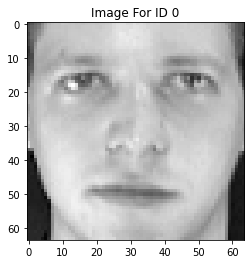

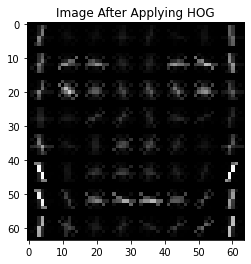

In [11]:
###### TASK - 4

from matplotlib.backends.backend_pdf import PdfPages
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from matplotlib import image
from scipy.stats import skew

import os, os.path
import matplotlib.pyplot as plt
import numpy as np
import sys


def read_folder_and_get_similar_images(folder_path, image_id, k):
    valid_images = [".jpg", ".png"]
    total_cost = {}
    cm_cost_dic = {}
    lbp_cost_dic = {}
    hog_cost_dic = {}

    max_cm = -(sys.maxsize - 1)
    min_cm = sys.maxsize
    max_lbp = -(sys.maxsize - 1)
    min_lbp = sys.maxsize
    max_hog = -(sys.maxsize - 1)
    min_hog = sys.maxsize

    main_image_matrix = image.imread(os.path.join(folder_path, image_id))
    main_image_color_moments = color_moment_model_single_image(main_image_matrix)
    main_image_lbp = local_binary_pattern_model_single_image(main_image_matrix)
    main_image_hog = histogram_of_oriented_gradients_model_single_image(main_image_matrix)

    for f in os.listdir(folder_path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        if f == image_id:
            continue

        image_matrix = image.imread(os.path.join(folder_path, f))
        image_color_moments = color_moment_model_single_image(image_matrix)
        image_lbp = local_binary_pattern_model_single_image(image_matrix)
        image_hog = histogram_of_oriented_gradients_model_single_image(image_matrix)

        cm_cost = np.linalg.norm(np.array(main_image_color_moments) - np.array(image_color_moments), ord=2)
        lbp_cost = np.linalg.norm(np.array(main_image_lbp) - np.array(image_lbp), ord=2)
        hog_cost = np.linalg.norm(np.array(main_image_hog) - np.array(image_hog), ord=2)

        cm_cost_dic[f] = cm_cost
        lbp_cost_dic[f] = lbp_cost
        hog_cost_dic[f] = hog_cost
        max_cm = max(cm_cost, max_cm)
        max_lbp = max(lbp_cost, max_lbp)
        max_hog = max(hog_cost, max_hog)
        min_cm = min(cm_cost, min_cm)
        min_lbp = min(lbp_cost, min_lbp)
        min_hog = min(hog_cost, min_hog)

    for key, value in cm_cost_dic.items():
        std_cm_cost = (value - min_cm) / (max_cm - min_cm)
        std_lbp_cost = (lbp_cost_dic[key] - min_lbp) / (max_lbp - min_lbp)
        std_hog_cost = (hog_cost_dic[key] - min_hog) / (max_hog - min_hog)

        total_image_cost = (std_cm_cost + std_lbp_cost + std_hog_cost) / 3
        total_cost[key] = total_image_cost

    total_cost = sorted(total_cost.items(), key=lambda x: x[1])
    if k <= len(total_cost):
        total_cost = total_cost[:k]

    output_file = PdfPages("output/task_4/" + os.path.splitext(image_id)[0] + '_output.pdf')
    first_page = plt.figure(num=None, figsize=(cm_to_inch(600), cm_to_inch(50)), dpi=80, facecolor='w', edgecolor='r')
    first_page.clf()
    title = 'ALL MODEL OUTPUT FOR THE ' + os.path.splitext(image_id)[0] + " for " + \
            str(k) + "-similar images"
    first_page.text(0.5, 0.5, title, transform=first_page.transFigure, size=300, ha="center")
    output_file.savefig()
    plt.close(first_page)

    actual_image = image.imread(os.path.join(folder_path, image_id))
    plot_actual_image = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(200)))
    plt.title("Actual Image", fontdict={'fontsize': 200})
    plt.imshow(actual_image, interpolation='nearest', cmap='gray')
    output_file.savefig(plot_actual_image)
    plt.close(plot_actual_image)

    for key, value in total_cost:
        image_file = image.imread(os.path.join(folder_path, key))
        plot_0 = plt.figure(figsize=(cm_to_inch(200), cm_to_inch(300)))
        plt.title("Color Moment Score = " + str(cm_cost_dic.get(key)) + "\nLBP Score = " +
                  str(lbp_cost_dic.get(key)) + "\nHOG Score = " + str(hog_cost_dic.get(key)) +
                  "\nOverall Score = " + str(value), fontdict={'fontsize': 200})
        plt.imshow(image_file, interpolation='nearest', cmap='gray')
        output_file.savefig(plot_0)
        plt.close(plot_0)

    output_file.close()
    return


def color_moment_model_single_image(image_array):
    color_moments = [[0] * 64 for _ in range(3)]
    count = 0

    for row in range(0, 8):
        for col in range(0, 8):
            sliced_image = image_array[row * 8:(row * 8) + 8, col * 8:(col * 8) + 8]

            color_moments[0][count] = sliced_image.mean()
            color_moments[1][count] = np.std(sliced_image)
            color_moments[2][count] = skew(skew(sliced_image))
            count += 1

    return color_moments


def local_binary_pattern_model_single_image(image_array):
    neighbour_set_points = 8
    radius = 1.00
    return local_binary_pattern(image_array, neighbour_set_points, radius, method='ror')


def histogram_of_oriented_gradients_model_single_image(image_array):
    feature_vector, hog_visualization = hog(image_array, orientations=9, pixels_per_cell=(8, 8),
                                            cells_per_block=(8, 8), block_norm='L2-Hys',
                                            visualize=True, multichannel=0)
    return feature_vector


def cm_to_inch(value):
    return value / 2.54


read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-392.png", 3)

read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-108.png", 5)

read_folder_and_get_similar_images(
    "/Users/keenan/Desktop/ASU/Semester 1/Multimedia and Web Databases/Project/Phase-1/olivetti_faces",
    "image-284.png", 8)
